<a href="https://colab.research.google.com/github/clementsiegrist/segmentation_probabilisticDL/blob/main/bayesiannet_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!wget https://raw.githubusercontent.com/clementsiegrist/segmentation_probabilisticDL/main/requirements.txt 
!pip3 install -r requirements.txt
!pip3 install --upgrade --force-reinstall --no-deps kaggle

In [2]:
%%capture
!git clone https://github.com/clementsiegrist/deep_seg.git
!git clone https://github.com/clementsiegrist/segmentation_probabilisticDL.git
!cp -r /content/segmentation_probabilisticDL/train.zip /content/deep_seg
!cp -r /content/segmentation_probabilisticDL/test.zip /content/deep_seg
!cp -r /content/segmentation_probabilisticDL/validation /content/deep_seg
!cd /content/deep_seg && unzip test.zip
!cd /content/deep_seg && unzip train.zip
!mkdir /content/weights
!rm -rf /content/segmentation_probabilisticDL /content/deep_seg/test.zip /content/deep_seg/train.zip /content/deep_seg/__MACOSX

In [3]:
train_path = "/content/deep_seg/train"
validation_path = "/content/deep_seg/validation"
test_path = "/content/deep_seg/test"
test_batch_size = 4
checkpoint_path = '/content/weights'
input_size = (256, 256) 
target_size = (256, 256) # (height, width) of input_size should be divisible by 32
num_class = 2
# fine tuning
train_batch_size = 4
test_batch_size = 4
validation_batch_size = 4
learning_rate = 1e-4
nb_epochs = 10

In [4]:
from PIL import Image
import cv2 as cv
import os
import numpy as np

In [5]:
%cd /content/deep_seg/
from unet_pipeline.main import main
from unet_pipeline.generator import load_pretrained, train_val_gen,predict_on_test_and_plot
import tensorflow.keras as keras

/content/deep_seg


Using TensorFlow backend.


Found 502 images belonging to 1 classes.
Found 502 images belonging to 1 classes.
Found 68 images belonging to 1 classes.
Found 68 images belonging to 1 classes.
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 16) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)       

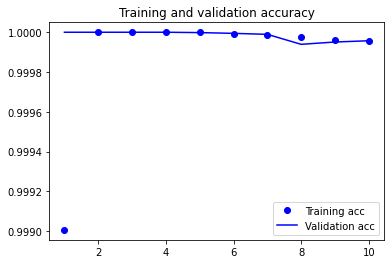

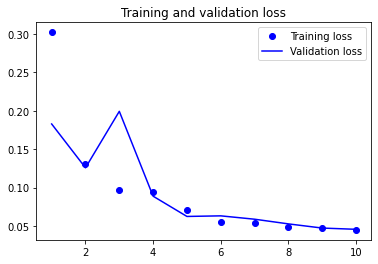

Found 0 images belonging to 1 classes.
Found 0 images belonging to 1 classes.


OSError: ignored

In [6]:
model_name = 'cell_seg.hdf5'
model = main(train_path, train_batch_size, validation_path, validation_batch_size, nb_epochs)
predict_on_test_and_plot(test_path, model_name=model_name, num=98)

In [7]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
model_name = 'cell_seg.hdf5'
predict_on_test_and_plot(test_path, model_name=model_name, num=96)

Found 100 images belonging to 1 classes.
Found 100 images belonging to 1 classes.


OSError: ignored

In [ ]:
%cd /content/
i = 1
train_percent = 0.7
data_size = 670
dim = (640,480)
path = '/content/train'
list_subfolders_with_paths = [f.path for f in os.scandir(path) if f.is_dir()]
train_size = int(data_size*train_percent)
test_size = data_size - train_size
for sub in list_subfolders_with_paths :
  folder_types = [f.path for f in os.scandir(sub) if f.is_dir()]
  if i < train_size : 
    os.mkdir('data/train/OP'+str(i))
  else :
    os.mkdir('data/test/OP'+str(i))
  for f_type in folder_types :
    if f_type.split('/')[-1] == 'masks': 
      onlyfiles = [f for f in os.listdir(f_type) if os.path.isfile(os.path.join(f_type, f))]
      src = f_type + '/' + onlyfiles[0]
      src1 = cv.imread(src)
      for img in onlyfiles : 
        src2 = cv.imread(f_type + '/' + img)
        alpha = 1
        beta = 1
        src1 = cv.addWeighted(src1, alpha, src2, beta, 0.0)
      img = cv.resize(src1, dim, interpolation = cv.INTER_AREA)
      if i < train_size :
        cv.imwrite('data/train/OP'+str(i)+'/img_' + str(i) + '_class.png',img)
      else :
        cv.imwrite('data/test/OP'+str(i)+'/img_' + str(i) + '_class.png',img)
    if f_type.split('/')[-1] == 'images':
      onlyfiles = [f for f in os.listdir(f_type) if os.path.isfile(os.path.join(f_type, f))]
      img_raw = cv.imread(f_type + '/' + onlyfiles[0])
      img = cv.resize(img_raw, dim, interpolation = cv.INTER_AREA)
      if i < train_size :
        cv.imwrite('data/train/OP'+str(i)+'/img_' + str(i) + '_raw.png',img)
      else :
        cv.imwrite('data/test/OP'+str(i)+'/img_' + str(i) + '_raw.png',img)
  i += 1
!rm -rf /content/train /content/{

In [5]:
%%capture
!git clone https://github.com/yuta-hi/pytorch-trainer
!cd pytorch-trainer && python setup.py install
!git clone https://github.com/IhabBendidi/pytorch_bayesian_unet 
!cd pytorch_bayesian_unet && pip install -r requirements.txt && python setup.py install


!cp -r /content/data/train /content/pytorch_bayesian_unet/examples/cellular_segmentation/train
!cp -r /content/data/test /content/pytorch_bayesian_unet/examples/cellular_segmentation/test


In [6]:
!python /content/pytorch_bayesian_unet/examples/cellular_segmentation/preprocess.py

# train images: 467
100% 467/467 [00:00<00:00, 3006.86it/s]
# train labels: 467
100% 467/467 [00:02<00:00, 201.44it/s]
# test images: 203
100% 203/203 [00:00<00:00, 2239.41it/s]
# test labels: 203
100% 203/203 [00:01<00:00, 199.57it/s]


In [7]:
!python /content/pytorch_bayesian_unet/examples/cellular_segmentation/train_and_test_epistemic.py --iteration 3000

GPU: cuda:0
# Minibatch-size: 2

# classes: 2
# samples:
-- train: 421
-- valid: 46
iteration   main/loss   validation/main/loss  main/accuracy  validation/main/accuracy  elapsed_time
0                       1.85458e+08                          0.329972                  4.454         
100         96541.2                           0.95007                                  46.1433       
     total [#.................................................]  3.33%
this epoch [#######################...........................] 47.51%
       100 iter, 0 epoch / 3000 iterations
       inf iters/sec. Estimated time to finish: 0:00:00.
200         56636                             0.942935                                 93.7185       
     total [###...............................................]  6.67%
this epoch [###############################################...] 95.01%
       200 iter, 0 epoch / 3000 iterations
    2.1019 iters/sec. Estimated time to finish: 0:22:12.103413.
300         68178.1

In [8]:
!python /content/pytorch_bayesian_unet/examples/cellular_segmentation/train_and_test_epistemic.py --test_on_test

GPU: cuda:0
# Minibatch-size: 2

# samples:
-- test: 203
Loaded a snapshot: logs/predictor_iter_00003000.pth
